# CIFAR-10 classification with a neural network
# Author: Alexey Gladyshev

## 1. Load CIFAR-10 dataset and prepare data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

In [2]:
np.random.seed(47)
dataset_root_path = '/home/agladyshev/Documents/UNN/DL/Datasets/cifar-10-batches-py'
weights_path = os.path.join('./weights', 'Lenet5XXX_weights_51_acc.tar')

In [3]:
from DataManager import DataManager

data_manager = DataManager(dataset_root_path, like_images=True)
X_train, X_val, y_train, y_val = data_manager.get_train_data()
X_test, y_test = data_manager.get_test_data()

## 2. NN implementation, layers, activations, loss functions and optimizer

In [4]:
from models.Lenet5XXX import Lenet5XXX
from loss_functions import SoftmaxCCE

## 3. Check correctness

In [5]:
network = Lenet5XXX(use_dropout=False, learning_rate=0.1)

Epoch 0
Loss:  5.229369087006906
Train accuracy:  0.5
Epoch 1
Loss:  1.4772289417362374
Train accuracy:  0.7
Epoch 2
Loss:  0.738630661003495
Train accuracy:  1.0
Epoch 3
Loss:  0.0768428415178187
Train accuracy:  1.0
Epoch 4
Loss:  0.022717956225387324
Train accuracy:  1.0


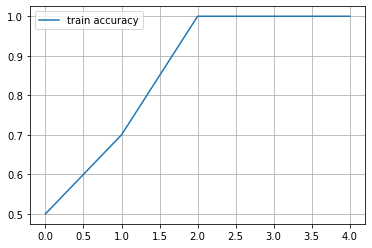

In [6]:
test_x_batch, test_y_batch = data_manager.get_test_batch(batch_size=10)

train_log = []
for epoch in range(5):
    loss = network.train_on_batch(test_x_batch, test_y_batch, SoftmaxCCE)
    train_log.append(np.mean(network.predict(test_x_batch, batch_step=32) == test_y_batch))
    print("Epoch", epoch)
    print("Loss: ", loss)
    print("Train accuracy: ", train_log[-1])

plt.plot(train_log, label='train accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

## 4. Experiments

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
network.load_state_dict(weights_path)

In [9]:
pred = network.predict(X_test, batch_step=32)

In [10]:
print('Test accuracy: ', accuracy_score(pred, y_test))

Test accuracy:  0.4614


In [11]:
print(confusion_matrix(pred, y_test))

[[371  23  44  31  23  10  12  14  67  25]
 [ 47 556  28  23  21  15  34  16  73 148]
 [ 89  13 249  54  81  71  44  41  15  22]
 [  9  11  49 156  35  82  42  31  18  20]
 [ 30   7 175  74 355  87  78  91  18   4]
 [ 29  21 149 327 115 510  57 136  27  24]
 [ 20  23 135 177 181  90 652  47  13  31]
 [ 35  22  75  56 118  84  26 518   9  37]
 [290  91  63  41  48  15  20  19 662 104]
 [ 80 233  33  61  23  36  35  87  98 585]]


## 5. Results
### The best NN architecture


### Learning rate strategy and batch size


### Data augmentations


### The best model test accuracy

